# Recommendations with IBM

In this project I'll analyze the interactions that users have with articles on the IBM Watson Studio platform, and make recommendations to them about new articles that they might like. The data and project concept our provided by [Udacity's course on Data Science](https://www.udacity.com/course/data-scientist-nanodegree--nd025).

## Load Data

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.simplefilter(action='ignore')

%matplotlib inline

df = pd.read_csv('../data/user-item-interactions.csv')
df_content = pd.read_csv('../data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [124]:
df['article_id'] = df['article_id'].astype('int').astype('str') 
df.head()

,article_id,title,email
0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [125]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [126]:
df_content['article_id'] = df_content['article_id'].astype('str') 

## Exploratory Data Analysis

### Duplicates 

In [127]:
df_content.duplicated('article_id').sum()

5

In [128]:
df_content = df_content.drop_duplicates('article_id')

In [129]:
# The number of unique articles that have an interaction with a user
len(df.article_id.unique())

714

In [130]:
# The number of unique articles in the dataset (whether they have any interactions or not)
df_content.shape[0]

1051

### Missing

In [131]:
# Count missing in df
df.isna().sum()

article_id     0
title          0
email         17
dtype: int64

In [132]:
# Count missing in df_content
df_content.isna().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [133]:
# The number of unique users in the dataset
len(df.dropna().email.unique())

5148

In [134]:
# The number of user-article interactions in the dataset
len(df)

45993

### Explore the data

In [135]:
# What is the distribution of how many articles a user interacts with in the dataset?
article_count = df.groupby('email')['article_id'].count()
article_count.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

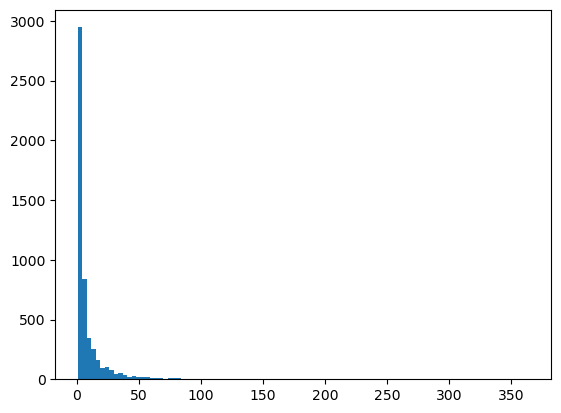

In [136]:
# What is the distribution of how many articles a user interacts with in the dataset?
plt.hist(article_count, bins=100);

In [137]:
# Most viewed article
user_count = df.groupby('article_id')['email'].count()

most_viewed_article_id = user_count.sort_values(ascending=False).index[0]
max_views = user_count.sort_values(ascending=False)[0]

print('Article #{} has the most views: {}'.format(most_viewed_article_id, max_views))

Article #1429 has the most views: 937


In [138]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


## Rank-Based Recommendations

We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

In [146]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby('title')['user_id'].count().sort_values(ascending=False)[:n]
    
    return top_articles.index # Return the top article titles from df

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby('article_id')['user_id'].count().sort_values(ascending=False)[:n]

    return top_articles.index # Return the top article ids

In [147]:
print(get_top_articles(10))
print(get_top_article_ids(10))

Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object', name='title')
Index(['1429', '1330', '1431', '1427', '1364', '1314', '1293', '1170', '1162',
       '1304'],
      dtype='object', name='article_id')
